# Metrics and Benchmarking for Convolution Complexity

Image smoothing is typically accomplished by convolving an N-dimensional Gaussian kernel with an N-dimensional input image. Spatial convolution slides the kernel along each voxel in the input image, performs elementwise multiplication, and adds the results to generate the corresponding pixel in the output image. Gaussian smoothing is accomplished with a separable kernel such that 1D convolution is performed in each of the N input image dimensions for the same result. FFT convolution transforms both the input image and kernel image into the frequency domain, performs elementwise complex multiplication, and transforms the product back into the spatial domain for output.

ITKVkFFTBackend leverages the VkFFT backend library to introduce GPU-accelerated FFT filters into the ITK pipeline. As a general rule, GPU-accelerated FFT smoothing outperforms CPU-based spatial smoothing for large kernel images or input images, while spatial smoothing continues to outperform FFT smoothing for small kernels or small images. For an application such as multiscale pyramid generation where many different kernel sizes are used, it is useful to be able to quantify where this tradeoff point occurs so that an automated pipeline may predictively select the filter anticipated to give the best performance for a given set of inputs.

The key variables influencing smoothing performance are kernel size and input image size. This notebook provides benchmarks operating in 3 dimensions, so kernel image side lengths are written as `I`, `J`, `K` while input image side lengths are written as `X`, `Y`, `Z`.

The theoretical complexity of a separable spatial convolution algorithm is as follows, where approximately `(I + J + K)` operations are performed on every voxel in the input image of size `X * Y * Z`:

`f(I,J,K,X,Y,Z) = (I + J + K) * X * Y * Z`

We use the metric `log(f)` to approximate the difference in expected performance of spatial or FFT smoothing for a given input image and kernel image combination. Several other metrics for comparison are also examined in this notebook.

For benchmarking comparison we develop two experiments:
- Runtime comparison over a range of values for `I` and `X`, with fixed `I == J == K` and `X == Y == Z`. This allows us to relatively quickly test a range of kernel and image sizes.
- Runtime comparison over a small set of values for `I`, `J`, `K`, `X`, `Y`, `Z`. This takes long (and includes some redundancy) but allows us to test interactions among non-cube images and kernels.

Smoothing performance differences are plotted for comparison.


In [1]:
import math
import time
import itertools

import itk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
pixel_type = itk.F
dimension = 3
image_type = itk.Image[pixel_type, dimension]
complex_image_type = itk.Image[itk.complex[pixel_type], dimension]


In [3]:
def is_vkfft_available():
    """Verify VkFFT overrides are present and initialized"""
    base_type = itk.ForwardFFTImageFilter[image_type, complex_image_type]
    vk_type = itk.VkForwardFFTImageFilter[image_type]

    try:
        vk_type.cast(base_type.New())
        return True
    except RuntimeError:
        # FFT overrides are either not available or not initialized properly
        return False


assert (
    is_vkfft_available()
), "VkFFT default overrides are not initialized. Please verify itk>=v5.3rc04 and itk-vkfft>=0.1.4"

# Manually adjust to match platform accelerated device
itk.VkGlobalConfiguration.SetDeviceID(1)


### Define benchmarking procedures

In [4]:
def get_kernel_radius(variance, direction, max_error=0.1, max_width=32):
    """Estimate the kernel radius to be used for smoothing"""
    oper = itk.GaussianOperator[itk.F, dimension]()
    oper.SetDirection(direction)
    oper.SetMaximumError(max_error)
    oper.SetMaximumKernelWidth(max_width)
    oper.SetVariance(
        variance if type(variance) in [float, int, np.float64] else variance[direction]
    )
    oper.CreateDirectional()
    return oper.GetRadius(direction)


In [5]:
def time_filter(itk_filter) -> float:
    """Return update timings"""
    starttime = time.time()
    itk_filter.Update()
    endtime = time.time()
    return endtime - starttime


def setup_gaussian_filter(
    gaussian_filter, image: image_type, variance: float, max_error=0.1, max_width=32
):
    """Set up filter with fixed parameters to compare timings"""
    gaussian_filter.SetInput(image)
    gaussian_filter.SetVariance(variance)
    gaussian_filter.SetMaximumError(max_error)
    gaussian_filter.SetMaximumKernelWidth(max_width)


In [6]:
def time_separable_gaussian_filter(image: image_type, variance: float) -> float:
    separable_filter = itk.DiscreteGaussianImageFilter[type(image), type(image)].New()
    setup_gaussian_filter(separable_filter, image, variance)
    return time_filter(separable_filter)


def time_fft_gaussian_filter(image: image_type, variance: float) -> float:
    fft_filter = itk.FFTDiscreteGaussianImageFilter[type(image), type(image)].New()
    setup_gaussian_filter(fft_filter, image, variance)
    return time_filter(fft_filter)


In [7]:
# 0 == cube images
# 1 == non-cube images
EXPERIMENT = 0

if EXPERIMENT == 0:
    kernel_variances_1D = np.logspace(0.25, 2.7, num=10)
    kernel_radii_1D = [
        get_kernel_radius(variance, 0) for variance in kernel_variances_1D
    ]
    assert len(set(kernel_radii_1D)) == len(kernel_radii_1D)  # No repeated kernel sizes
    kernel_variances = list(zip(*([kernel_variances_1D] * 3)))
    print(f"Kernel variance input: {kernel_variances_1D}")
    print(f"Corresponding kernel radii: {kernel_radii_1D}")

    image_lens_1D = np.linspace(10, 350, num=15).astype(np.uint16)
    image_sizes = list(zip(*([image_lens_1D] * 3)))
    print(f"Image side lengths: {image_lens_1D}")

elif EXPERIMENT == 1:
    # Benchmark with non-homogeneous variances and image sizes
    kernel_variances_1D = np.logspace(0.25, 2.7, num=3)
    kernel_radii_1D = [
        get_kernel_radius(variance, 0) for variance in kernel_variances_1D
    ]
    kernel_variances = list(itertools.product(*([kernel_variances_1D] * 3)))
    print(f"Kernel variance is 3D Cartesian product of: {kernel_variances_1D}")
    print(f"Corresponding kernel radii: {kernel_radii_1D}")

    image_lens_1D = np.linspace(10, 350, num=3).astype(np.uint16)
    image_sizes = list(itertools.product(image_lens_1d, image_lens_1d, image_lens_1d))
    print(f"Image size is 3D Cartesian product of: {image_lens_1D}")

    # kernel_radii = [[get_kernel_radius(variance, dim) for dim in range(dimension)] for variance in kernel_variances]


Kernel variance input: [  1.77827941   3.32829814   6.22937455  11.65914401  21.82171548
  40.84238653  76.44222743 143.07229892 267.77977837 501.18723363]
Corresponding kernel radii: [2, 3, 4, 6, 8, 10, 14, 20, 27, 32]
Image side lengths: [ 10  34  58  82 107 131 155 180 204 228 252 277 301 325 350]


In [8]:
# metric_vals = np.zeros([len(kernel_variances) * len(image_sizes), metric_count])
def calc_threshold_metric(kernel_size, image_sizes):
    return np.sum(kernel_size) * np.product(image_sizes)


threshold_metric_vals = np.zeros([len(kernel_variances) * len(image_sizes)])

for sample_idx, (variance, image_size) in enumerate(
    tqdm(itertools.product(kernel_variances, image_sizes))
):
    assert len(variance) == 3 and len(image_size) == 3
    kernel_radius = [get_kernel_radius(variance, dim) for dim in range(dimension)]
    kernel_size = [kernel_radius[dim] * 2 + 1 for dim in range(dimension)]
    threshold_metric_vals[sample_idx] = calc_threshold_metric(kernel_size, image_size)

    # for metric_idx in range(metric_count):
    # metric_vals[sample_idx, metric_idx] = metric_fns[metric_idx](kernel_size, image_size)


150it [00:00, 471.71it/s] 


## Run Benchmarking

Benchmarking runs spatial and FFT convolution for each kernel/input combination. May take between 5 and 30 minutes depending on hardware.

In [9]:
spatial_times = list()
fft_times = list()

print(f"Index\tKernel Radius\tImage Len\tSpatial\tFFT\tBest")

for idx, (variance, image_size) in enumerate(
    itertools.product(kernel_variances, image_sizes)
):
    image = itk.image_from_array(np.random.random_sample(image_size).astype(np.float32))
    spatial_runtime = time_separable_gaussian_filter(image, variance)
    spatial_times.append(spatial_runtime)

    fft_runtime = time_fft_gaussian_filter(image, variance)
    fft_times.append(fft_runtime)

    kernel_radius = [get_kernel_radius(variance, dim) for dim in range(3)]

    best = "fft" if fft_runtime < spatial_runtime else "spatial"
    print(
        f"{idx}\t{kernel_radius}\t{image_size}\t"
        f"{spatial_runtime:0.4f}\t{fft_runtime:0.4f}\t{best}"
    )


Index	Kernel Radius	Image Len	Spatial	FFT	Best
0	[2, 2, 2]	(10, 10, 10)	0.0050	1.4397	spatial
1	[2, 2, 2]	(34, 34, 34)	0.0070	0.2809	spatial
2	[2, 2, 2]	(58, 58, 58)	0.0100	0.2693	spatial
3	[2, 2, 2]	(82, 82, 82)	0.0160	0.2793	spatial
4	[2, 2, 2]	(107, 107, 107)	0.0230	0.3458	spatial
5	[2, 2, 2]	(131, 131, 131)	0.0386	0.3742	spatial
6	[2, 2, 2]	(155, 155, 155)	0.0530	0.4222	spatial
7	[2, 2, 2]	(180, 180, 180)	0.0690	0.5319	spatial
8	[2, 2, 2]	(204, 204, 204)	0.1056	0.5979	spatial
9	[2, 2, 2]	(228, 228, 228)	0.1249	0.7498	spatial
10	[2, 2, 2]	(252, 252, 252)	0.1780	0.9287	spatial
11	[2, 2, 2]	(277, 277, 277)	0.2401	1.2555	spatial
12	[2, 2, 2]	(301, 301, 301)	0.2970	1.3794	spatial
13	[2, 2, 2]	(325, 325, 325)	0.3551	1.6490	spatial
14	[2, 2, 2]	(350, 350, 350)	0.4661	2.0313	spatial
15	[3, 3, 3]	(10, 10, 10)	0.0070	0.3213	spatial
16	[3, 3, 3]	(34, 34, 34)	0.0070	0.2909	spatial
17	[3, 3, 3]	(58, 58, 58)	0.0120	1.1831	spatial
18	[3, 3, 3]	(82, 82, 82)	0.0180	0.2795	spatial
19	[3, 3, 3]	(107,

## Examine Results

In [10]:
fft_difference = np.array(spatial_times) - np.array(fft_times)
fft_ratio = np.array(spatial_times) / np.array(fft_times) * 100  # percentage


In [11]:
def plot_result(metric, ratio, difference, title, logx=False, logy=False):
    assert len(metric) == len(ratio) and len(metric) == len(difference)

    fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
    axs[0].scatter(metric, ratio)
    axs[0].set_yscale("log")
    axs[0].set_ylabel("FFT Relative Speed (%)")

    axs[1].scatter(metric, difference)
    axs[1].set_ylabel("Spatial - FFT Performance (s)")

    for ax in axs:
        ax.set_xlabel("Metric value")
        if logx:
            ax.set_xscale("log")
        ax.set_title(title)
        ax.grid(True, which="both")

    plt.show()


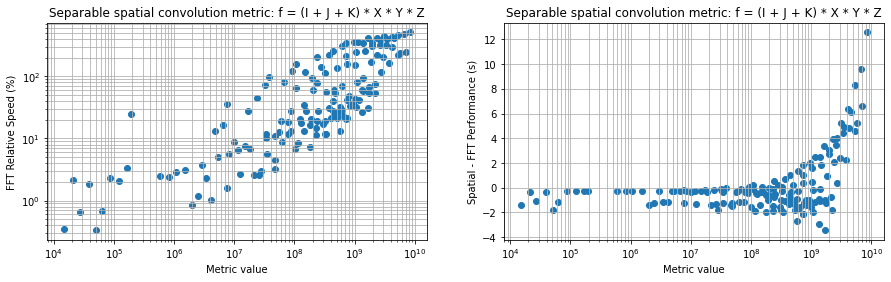

In [12]:
plot_result(
    threshold_metric_vals,
    fft_ratio,
    fft_difference,
    "Separable spatial convolution metric: f = (I + J + K) * X * Y * Z",
    logy=True,
    logx=True,
)


### Compare with Other Metrics

Several other metrics were considered for predicting performance tradeoff among spatial and FFT convolution. We invite the user to experiment with their own metrics as well.

In [13]:
metric_fns = [
    (
        "f = (I + J + K) / (log_2(X) + log_2(Y) + log_2(Z))",
        lambda k, s: np.sum(k) / np.sum([math.log(l, 2) for l in s]),
    ),
    ("f = (I + J + K)", lambda k, s: np.sum(k)),
    ("f = max(I,J,K)", lambda k, s: np.max(k)),
    (
        "f = (log_2(X) + log_2(Y) + log_2(Z)) / (I + J + K))",
        lambda k, s: np.sum([math.log(l, 2) for l in s]) / np.sum(k),
    ),
    (
        "f = (log_2(X) + log_2(Y) + log_2(Z)) * (I + J + K))",
        lambda k, s: np.sum([math.log(l, 2) for l in s]) * np.sum(k),
    ),
    ("f = I * J * K * X * Y * Z", lambda k, s: np.product(k) * np.product(s)),
    (
        "f = I * J * K * log_2(X) * log_2(Y) * log_2(Z)",
        lambda k, s: np.product(k) * np.product([math.log(l, 2) for l in s]),
    ),
    ("f = X * Y * Z", lambda k, s: np.product(s)),
]

metric_count = len(metric_fns)
print(f"Defined {metric_count} metrics")


Defined 8 metrics


In [14]:
metric_vals = np.zeros([len(kernel_variances) * len(image_sizes), metric_count])

for sample_idx, (variance, image_size) in enumerate(
    tqdm(itertools.product(kernel_variances, image_sizes))
):
    assert len(variance) == 3 and len(image_size) == 3
    kernel_radius = [get_kernel_radius(variance, dim) for dim in range(dimension)]
    kernel_size = [kernel_radius[dim] * 2 + 1 for dim in range(dimension)]

    for metric_idx in range(metric_count):
        metric_vals[sample_idx, metric_idx] = metric_fns[metric_idx][1](
            kernel_size, image_size
        )


150it [00:00, 450.39it/s] 


In [15]:
def plot_metric(idx: int, logx=True):
    plot_result(
        metric_vals[:, idx],
        fft_ratio,
        fft_difference,
        metric_fns[idx][0],
        logy=True,
        logx=logx,
    )


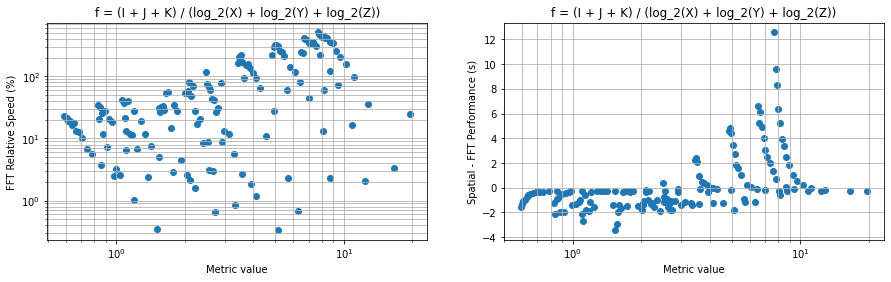

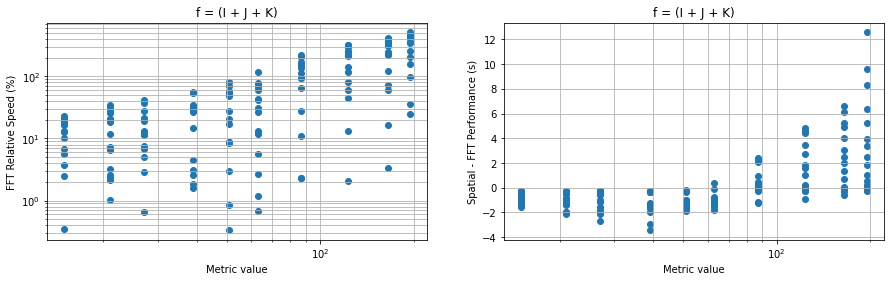

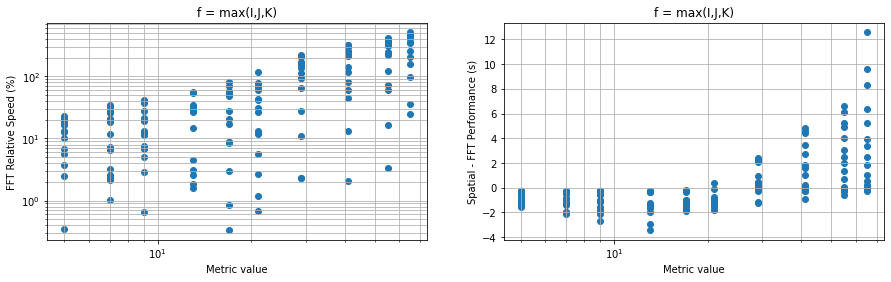

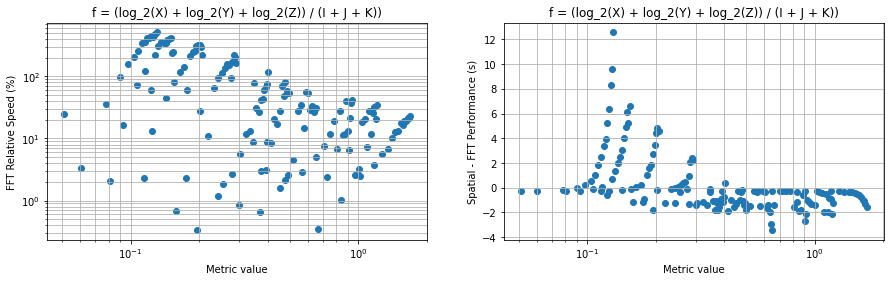

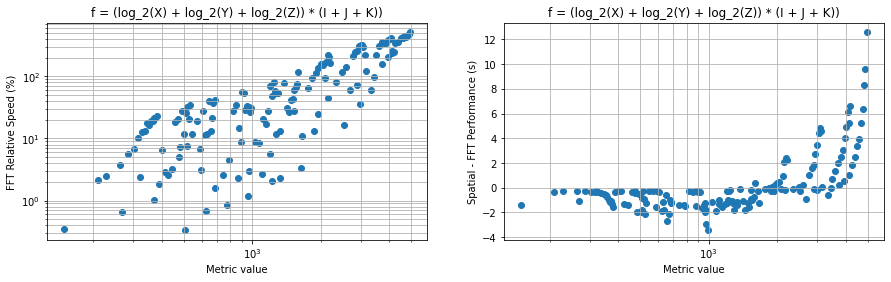

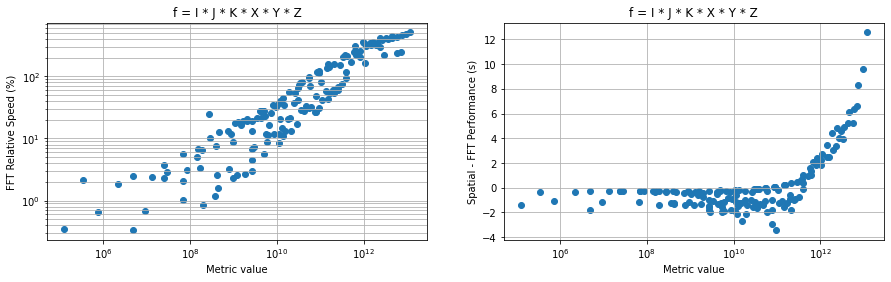

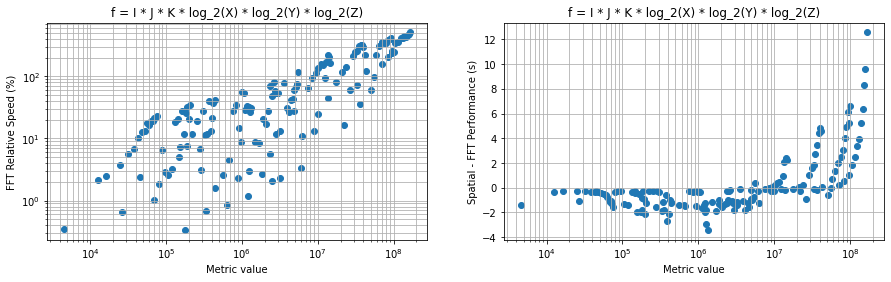

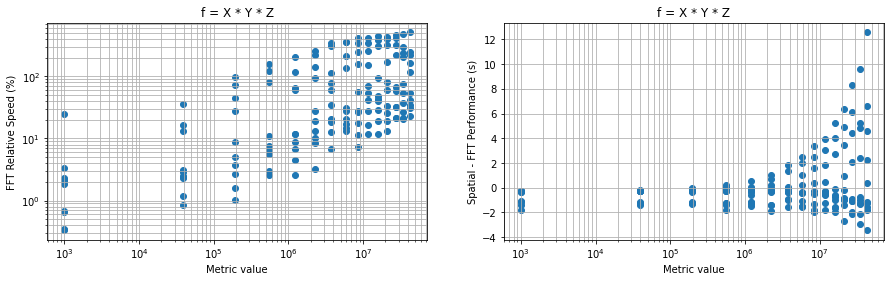

In [16]:
for idx in range(metric_count):
    plot_metric(idx)
